In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
import pandas as pd
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
import math
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator
from matplotlib import ticker

# Start Spark session
spark = SparkSession.builder \
    .appName("OPSData") \
    .config("spark.mongodb.input.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Optional: reduce log noise
spark.sparkContext.setLogLevel("WARN")


In [2]:
# Place the .csv file in the following path or change the path accordingly

base_path = os.path.expanduser("~/Documents/SparkNotebooks/opsd")
file_name = "time_series_60min_singleindex.csv"

file_path = os.path.join(base_path, file_name)

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Dataset is really wide and can't be viewed properly in notebooks
df.show(5)


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [3]:
df.printSchema()         # See all the columns and data types

root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [4]:
df.columns               # Get list of column names

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [5]:
# Number of columns
len(df.columns)

300

In [6]:
df.select("utc_timestamp", "IE_load_actual_entsoe_transparency").show(10)

+-------------------+----------------------------------+
|      utc_timestamp|IE_load_actual_entsoe_transparency|
+-------------------+----------------------------------+
|2015-01-01 01:00:00|                              NULL|
|2015-01-01 02:00:00|                            2832.0|
|2015-01-01 03:00:00|                            2678.0|
|2015-01-01 04:00:00|                            2432.0|
|2015-01-01 05:00:00|                            2276.0|
|2015-01-01 06:00:00|                            2173.0|
|2015-01-01 07:00:00|                            2136.0|
|2015-01-01 08:00:00|                            2166.0|
|2015-01-01 09:00:00|                            2215.0|
|2015-01-01 10:00:00|                            2237.0|
+-------------------+----------------------------------+
only showing top 10 rows



In [7]:
# Count rows
df.count()

50401

In [8]:
# Basic stats on a numeric column
df.describe("IE_load_actual_entsoe_transparency").show()

+-------+----------------------------------+
|summary|IE_load_actual_entsoe_transparency|
+-------+----------------------------------+
|  count|                             49837|
|   mean|                3191.2216425547285|
| stddev|                 608.6479345942973|
|    min|                            1790.0|
|    max|                            5018.0|
+-------+----------------------------------+



In [9]:
# Get null counts
nulls = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Convert to Pandas and sort by null count
nulls_pd = nulls.toPandas().T
nulls_pd.columns = ['null_count']
nulls_pd = nulls_pd.sort_values(by='null_count', ascending=False)

# Show top 20 columns with most nulls
nulls_pd.head(20)


,null_count
HR_solar_generation_actual,50391
HR_wind_onshore_generation_actual,50379
PT_wind_offshore_generation_actual,47509
PT_wind_generation_actual,47509
PL_solar_generation_actual,46237
HU_solar_generation_actual,41436
SK_wind_onshore_generation_actual,40722
NO_5_wind_onshore_generation_actual,40132
NO_1_wind_onshore_generation_actual,35815
DE_LU_load_forecast_entsoe_transparency,33745


In [10]:
# Show 20 columns with least nulls
nulls_pd.tail(20)

,null_count
BE_load_actual_entsoe_transparency,1
DE_amprion_load_forecast_entsoe_transparency,1
DE_tennet_wind_onshore_generation_actual,1
DE_amprion_load_actual_entsoe_transparency,1
DE_50hertz_load_forecast_entsoe_transparency,1
DE_50hertz_wind_generation_actual,1
DE_50hertz_wind_offshore_generation_actual,1
DE_50hertz_load_actual_entsoe_transparency,1
DE_50hertz_wind_onshore_generation_actual,1
DE_amprion_wind_onshore_generation_actual,1


### Preprocessing

In [11]:
# Drop duplicates
df_no_duplicates = df.dropDuplicates()
df_no_duplicates.count()

50401

In [12]:
%%script skipping
# Replace nulls with median values in specific columns --- Removed for now, nulls are replaced with zeroes

from pyspark.sql.functions import percentile_approx
from pyspark.sql.types import NumericType

# Function to compute median for a column (using percentile_approx)
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Get numeric columns in the DataFrame
numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, NumericType)]

# Compute median values for all numeric columns in parallel
median_values = {}
for c in numeric_columns:
    try:
        median_val = get_median(df, c)
        median_values[c] = median_val
    except Exception as e:
        print(f"Skipping column {c}: {e}")

# Apply the fillna operation for all numeric columns with their respective medians
df_filled = df
for c, median_val in median_values.items():
    df_filled = df_filled.fillna({c: median_val})

df_filled.show(5)  # Show the first 5 rows of the filled DataFrame


Couldn't find program: 'skipping'


In [13]:
# Get a list of country codes from the column names
country_codes = set(
    col.split('_')[0] for col in df.columns if len(col.split('_')) > 1 and len(col.split('_')[0]) == 2 and col.split('_')[0].isalpha()
)

print(country_codes)


{'PL', 'RS', 'AT', 'GR', 'RO', 'DK', 'BG', 'SI', 'SE', 'HR', 'GB', 'CY', 'IE', 'IT', 'UA', 'CH', 'SK', 'ES', 'NL', 'EE', 'LT', 'ME', 'PT', 'LU', 'BE', 'NO', 'CZ', 'DE', 'FI', 'HU', 'LV', 'FR'}


In [14]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

In [15]:
print(df.columns)

['utc_timestamp', 'cet_cest_timestamp', 'AT_load_actual_entsoe_transparency', 'AT_load_forecast_entsoe_transparency', 'AT_price_day_ahead', 'AT_solar_generation_actual', 'AT_wind_onshore_generation_actual', 'BE_load_actual_entsoe_transparency', 'BE_load_forecast_entsoe_transparency', 'BE_solar_generation_actual', 'BE_wind_generation_actual', 'BE_wind_offshore_generation_actual', 'BE_wind_onshore_generation_actual', 'BG_load_actual_entsoe_transparency', 'BG_load_forecast_entsoe_transparency', 'BG_solar_generation_actual', 'BG_wind_onshore_generation_actual', 'CH_load_actual_entsoe_transparency', 'CH_load_forecast_entsoe_transparency', 'CH_solar_capacity', 'CH_solar_generation_actual', 'CH_wind_onshore_capacity', 'CH_wind_onshore_generation_actual', 'CY_load_actual_entsoe_transparency', 'CY_load_forecast_entsoe_transparency', 'CY_wind_onshore_generation_actual', 'CZ_load_actual_entsoe_transparency', 'CZ_load_forecast_entsoe_transparency', 'CZ_solar_generation_actual', 'CZ_wind_onshore_ge

In [16]:
df = df.withColumn("timestamp", to_timestamp("utc_timestamp"))
df = df.drop("utc_timestamp", "cet_cest_timestamp")  # drop original date columns

### Data to MongoDB

In [17]:
# Function to process and insert data
def process_columns(df):
    timestamp_col = "timestamp"
    country_cols = {}

    # Organize columns by country prefix
    for col_name in df.columns:
        if col_name == timestamp_col:
            continue
        parts = col_name.split("_")
        country_prefix = parts[0]
        
        # Handle multi-country prefixes like 'DE_LU'
        if len(parts) > 1 and ('price' in parts[1] or 'generation' in parts[1] or 'capacity' in parts[1]):
            countries = country_prefix.split("_")
            for c in countries:
                country_cols.setdefault(c, []).append(col_name)
        else:
            country_cols.setdefault(country_prefix, []).append(col_name)

    docs = []
    
    # Collect the rows from the PySpark DataFrame as a list of Row objects
    rows = df.collect()

    # Process each row
    for row in rows:
        timestamp = row[timestamp_col]

        for country, cols in country_cols.items():
            doc = {
                "timestamp": timestamp,
                "country": country,
                "consumption": 0,
                "consumption_forecast": 0,
                "price_day_ahead": 0,
                "generation": {},
                "capacity": {},
                "profile": {}
            }

            # Process each relevant column for the country
            for col_name in cols:
                value = row[col_name]

                if value is None or (isinstance(value, (float, int)) and math.isnan(value)):
                    continue

                parts = col_name.split("_")
                field = "_".join(parts[1:])

                if "load_actual" in field and "transnetbw" not in field and "tennet" not in field and "amprion" not in field and "50hertz" not in field and "LU" not in field:
                    doc["consumption"] = float(value)
                elif "load_forecast" in field and "transnetbw" not in field and "tennet" not in field and "amprion" not in field and "50hertz" not in field and "LU" not in field:
                    doc["consumption_forecast"] = float(value)
                elif "price_day_ahead" in field:
                    doc["price_day_ahead"] = float(value)
                elif "generation" in field:
                    key = field.replace("_generation", "")
                    doc["generation"][f"{key}_generation"] = float(value)
                elif "capacity" in field:
                    key = field.replace("_capacity", "")
                    doc["capacity"][f"{key}_capacity"] = float(value)
                elif "profile" in field:
                    key = field.replace("_profile", "")
                    doc["profile"][f"{key}_profile"] = float(value)

            docs.append(doc)

    # Insert the documents into MongoDB if any are prepared
    if docs:
        try:
            collection.insert_many(docs)
            print(f"{len(docs)} documents inserted successfully.")  # Debugging line
        except Exception as e:
            print("Error inserting documents:", e)  # Debugging line

# Call the function to process the DataFrame
process_columns(df)


1612832 documents inserted successfully.


### Data from MongoDB

In [18]:
# Read data from MongoDB with the defined schema
df_read = spark.read.format("mongo").load()

# Print the schema to understand the structure of the data
df_read.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- capacity: struct (nullable = true)
 |    |-- GBN_solar_capacity: double (nullable = true)
 |    |-- GBN_wind_capacity: double (nullable = true)
 |    |-- GBN_wind_offshore_capacity: double (nullable = true)
 |    |-- GBN_wind_onshore_capacity: double (nullable = true)
 |    |-- NIR_solar_capacity: double (nullable = true)
 |    |-- NIR_wind_onshore_capacity: double (nullable = true)
 |    |-- UKM_solar_capacity: double (nullable = true)
 |    |-- UKM_wind_capacity: double (nullable = true)
 |    |-- UKM_wind_offshore_capacity: double (nullable = true)
 |    |-- UKM_wind_onshore_capacity: double (nullable = true)
 |    |-- solar_capacity: double (nullable = true)
 |    |-- wind_capacity: double (nullable = true)
 |    |-- wind_offshore_capacity: double (nullable = true)
 |    |-- wind_onshore_capacity: double (nullable = true)
 |-- consumption: double (nullable = true)
 |-- consumption_forecast: double 

In [19]:
df_read.columns

['_id',
 'capacity',
 'consumption',
 'consumption_forecast',
 'country',
 'generation',
 'price_day_ahead',
 'profile',
 'timestamp']

In [20]:
# Filter for data where country is 'DE'
df_de = df_read.filter(df_read.country == "DE").cache()
# Show the filtered data for DE
df_de.show(10, truncate=False)

+--------------------------+----------------------------------------------------------------------------------------------+-----------+--------------------+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+--------------------------------------------------------+-------------------+
|_id                       |capacity                                                                                      |consumption|consumption_forecast|country|generation                                                                                                                                                                                           

In [21]:

# Extract the 'timestamp', 'wind_actual_generation', and 'solar_actual_generation' columns, and convert 'timestamp' to a date
# Extract fields from the 'generation' struct
df_mongo = df_de.select(
    "timestamp",
    col("generation.wind_actual_generation").alias("wind_actual_generation"),
    col("generation.solar_actual_generation").alias("solar_actual_generation")
).withColumn("date", to_date(col("timestamp"))).cache()

# Calculate daily averages of both wind and solar generation in one step
daily_avg_df = df_mongo.groupBy("date").agg(
    avg("wind_actual_generation").alias("avg_wind_generation"),
    avg("solar_actual_generation").alias("avg_solar_generation")
).cache()

# Sort by date
daily_avg_df = daily_avg_df.orderBy("date")

# Show the daily averages
daily_avg_df.show(20)


+----------+-------------------+--------------------+
|      date|avg_wind_generation|avg_solar_generation|
+----------+-------------------+--------------------+
|2015-01-01|            11951.1|  1315.2307692307693|
|2015-01-02|          24670.125|   323.2083333333333|
|2015-01-03| 20597.541666666668|   301.5416666666667|
|2015-01-04|           16706.25|   832.5833333333334|
|2015-01-05|          10783.125|  1105.0833333333333|
|2015-01-06|           3653.875|  1370.3333333333333|
|2015-01-07|  8599.458333333334|   713.0833333333334|
|2015-01-08|          16999.875|   358.2916666666667|
|2015-01-09|           26895.75|              284.25|
|2015-01-10| 25876.666666666668|   853.0416666666666|
|2015-01-11| 26227.666666666668|   825.4583333333334|
|2015-01-12| 26347.916666666668|             459.375|
|2015-01-13| 22571.583333333332|            2095.125|
|2015-01-14| 17446.333333333332|   754.4166666666666|
|2015-01-15| 21736.083333333332|   714.7916666666666|
|2015-01-16| 13659.208333333

### Plotting

In [22]:
df_read.createOrReplaceTempView("generation_data")

# Query using SparkSQL
sql_query = """
    SELECT
        to_date(timestamp) AS date,
        AVG(generation.wind_actual_generation) AS avg_wind_generation,
        AVG(generation.solar_actual_generation) AS avg_solar_generation
    FROM generation_data
    WHERE country = 'DE'
    GROUP BY date
    ORDER BY date
"""

# Run the SQL query
daily_avg_df_sql = spark.sql(sql_query)

daily_avg_df_sql.cache()

# Show the result
daily_avg_df_sql.show(20)

+----------+-------------------+--------------------+
|      date|avg_wind_generation|avg_solar_generation|
+----------+-------------------+--------------------+
|2015-01-01|            11951.1|  1315.2307692307693|
|2015-01-02|          24670.125|   323.2083333333333|
|2015-01-03| 20597.541666666668|   301.5416666666667|
|2015-01-04|           16706.25|   832.5833333333334|
|2015-01-05|          10783.125|  1105.0833333333333|
|2015-01-06|           3653.875|  1370.3333333333333|
|2015-01-07|  8599.458333333334|   713.0833333333334|
|2015-01-08|          16999.875|   358.2916666666667|
|2015-01-09|           26895.75|              284.25|
|2015-01-10| 25876.666666666668|   853.0416666666666|
|2015-01-11| 26227.666666666668|   825.4583333333334|
|2015-01-12| 26347.916666666668|             459.375|
|2015-01-13| 22571.583333333332|            2095.125|
|2015-01-14| 17446.333333333332|   754.4166666666666|
|2015-01-15| 21736.083333333332|   714.7916666666666|
|2015-01-16| 13659.208333333

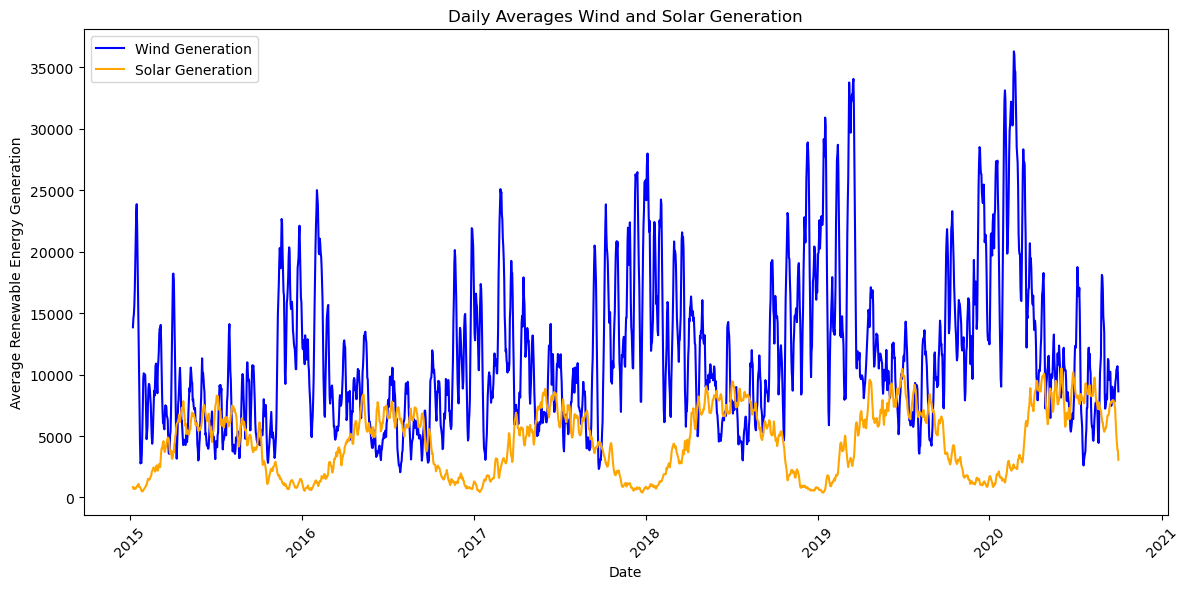

In [23]:
# Convert the PySpark DataFrame to a Pandas DataFrame
daily_avg_pd_sql = daily_avg_df_sql.toPandas()
daily_avg_pd_sql['date'] = pd.to_datetime(daily_avg_pd_sql['date'])
daily_avg_pd_sql.set_index('date', inplace=True)
daily_avg_pd_sql = daily_avg_pd_sql.resample('D').mean()
daily_avg_pd_sql = daily_avg_pd_sql.interpolate(method='linear')
daily_avg_pd_sql = daily_avg_pd_sql.rolling(window=7).mean()
daily_avg_pd_sql = daily_avg_pd_sql.dropna()
daily_avg_pd_sql.reset_index(inplace=True)
daily_avg_pd_sql['date'] = pd.to_datetime(daily_avg_pd_sql['date'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_pd_sql['date'], daily_avg_pd_sql['avg_wind_generation'], label='Wind Generation', color='blue')
plt.plot(daily_avg_pd_sql['date'], daily_avg_pd_sql['avg_solar_generation'], label='Solar Generation', color='orange')
plt.xlabel('Date')
plt.ylabel('Average Renewable Energy Generation')
plt.title('Daily Averages Wind and Solar Generation')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [24]:
df_read.createOrReplaceTempView("generation_data")

# Query using SparkSQL
sql_query = """
    SELECT
        to_date(timestamp) AS date,
        SUM(generation.wind_actual_generation + generation.solar_actual_generation) AS total_renewables_generation,
        SUM(consumption) AS total_consumption
    FROM generation_data
    WHERE country = 'DE'
    GROUP BY date
    ORDER BY date
"""

# Run the SQL query
daily_sum_df_sql = spark.sql(sql_query)

daily_sum_df_sql.cache()

# Show the result
daily_sum_df_sql.show(20)

+----------+---------------------------+-----------------+
|      date|total_renewables_generation|total_consumption|
+----------+---------------------------+-----------------+
|2015-01-01|                   762920.0|        3611484.0|
|2015-01-02|                  2399360.0|        4969480.0|
|2015-01-03|                  2006312.0|        4490632.0|
|2015-01-04|                  1683728.0|        4320692.0|
|2015-01-05|                  1141268.0|        5213320.0|
|2015-01-06|                   482324.0|        5323704.0|
|2015-01-07|                   894004.0|        5717248.0|
|2015-01-08|                  1666384.0|        5916548.0|
|2015-01-09|                  2609280.0|        5856004.0|
|2015-01-10|                  2566052.0|        5059112.0|
|2015-01-11|                  2597100.0|        4624532.0|
|2015-01-12|                  2573500.0|        5842332.0|
|2015-01-13|                  2368004.0|        5887296.0|
|2015-01-14|                  1747272.0|        5826872.

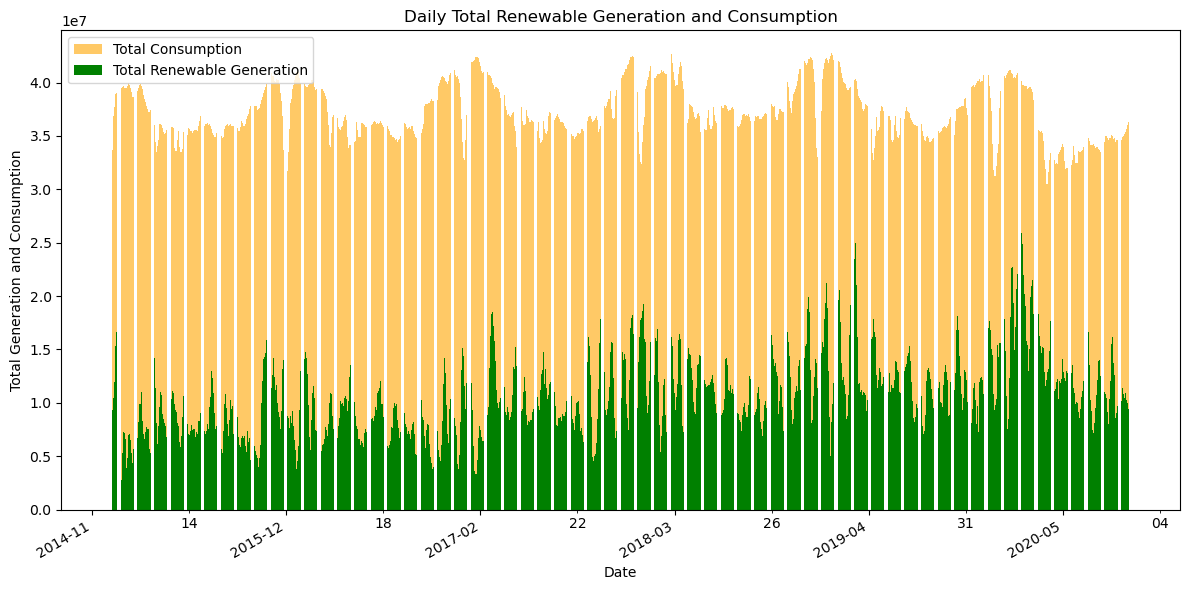

In [25]:
# Convert the PySpark DataFrame to a Pandas DataFrame
daily_sum_pd_sql = daily_sum_df_sql.toPandas()
daily_sum_pd_sql['date'] = pd.to_datetime(daily_sum_pd_sql['date'])
daily_sum_pd_sql.set_index('date', inplace=True)
daily_sum_pd_sql = daily_sum_pd_sql.resample('D').sum()
daily_sum_pd_sql = daily_sum_pd_sql.interpolate(method='linear')
daily_sum_pd_sql = daily_sum_pd_sql.rolling(window=7).sum()
daily_sum_pd_sql = daily_sum_pd_sql.dropna()
daily_sum_pd_sql.reset_index(inplace=True)
daily_sum_pd_sql['date'] = pd.to_datetime(daily_sum_pd_sql['date'])


# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(daily_sum_pd_sql['date'], daily_sum_pd_sql['total_consumption'], label='Total Consumption', color='orange', alpha=0.6)
plt.bar(daily_sum_pd_sql['date'], daily_sum_pd_sql['total_renewables_generation'], label='Total Renewable Generation', color='green', alpha=1)
plt.xlabel('Date')
plt.ylabel('Total Generation and Consumption')
plt.title('Daily Total Renewable Generation and Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gca().xaxis.set_minor_locator(DayLocator())
plt.gca().xaxis.set_minor_formatter(DateFormatter('%d'))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='both'))
plt.gca().xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12, prune='both'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [26]:
df_read.createOrReplaceTempView("generation_data")

# Query using SparkSQL
sql_query = """
    SELECT
        year(timestamp) AS year,
        weekofyear(timestamp) AS week,
        SUM(generation.solar_actual_generation) AS total_solar_generation,
        SUM(generation.wind_actual_generation) AS total_wind_generation,
        SUM(capacity.solar_capacity) AS total_solar_capacity,
        SUM(capacity.wind_capacity) AS total_wind_capacity
    FROM
        generation_data
    WHERE
        country = 'DE'
    GROUP BY
        year, week
    ORDER BY
        year, week
"""

# Run the SQL query
weekly_gen_df_sql = spark.sql(sql_query)

weekly_gen_df_sql.cache()

# Show the result
weekly_gen_df_sql.show(20)

+----+----+----------------------+---------------------+--------------------+-------------------+
|year|week|total_solar_generation|total_wind_generation|total_solar_capacity|total_wind_capacity|
+----+----+----------------------+---------------------+--------------------+-------------------+
|2015|   1|              208296.0|            6905584.0|         1.3856808E7|        1.0387224E7|
|2015|   2|              528916.0|          1.1427496E7|         2.5036584E7|        1.8789336E7|
|2015|   3|              688204.0|          1.0835708E7|         2.5044516E7|        1.8811476E7|
|2015|   4|              388520.0|            1884148.0|          2.506284E7|        1.8848352E7|
|2015|   5|              523552.0|            6675216.0|         2.5090704E7|        1.8896484E7|
|2015|   6|             1017548.0|            5162436.0|         2.5109616E7|        1.8961224E7|
|2015|   7|             1201720.0|            4054496.0|          2.511258E7|        1.9013772E7|
|2015|   8|         

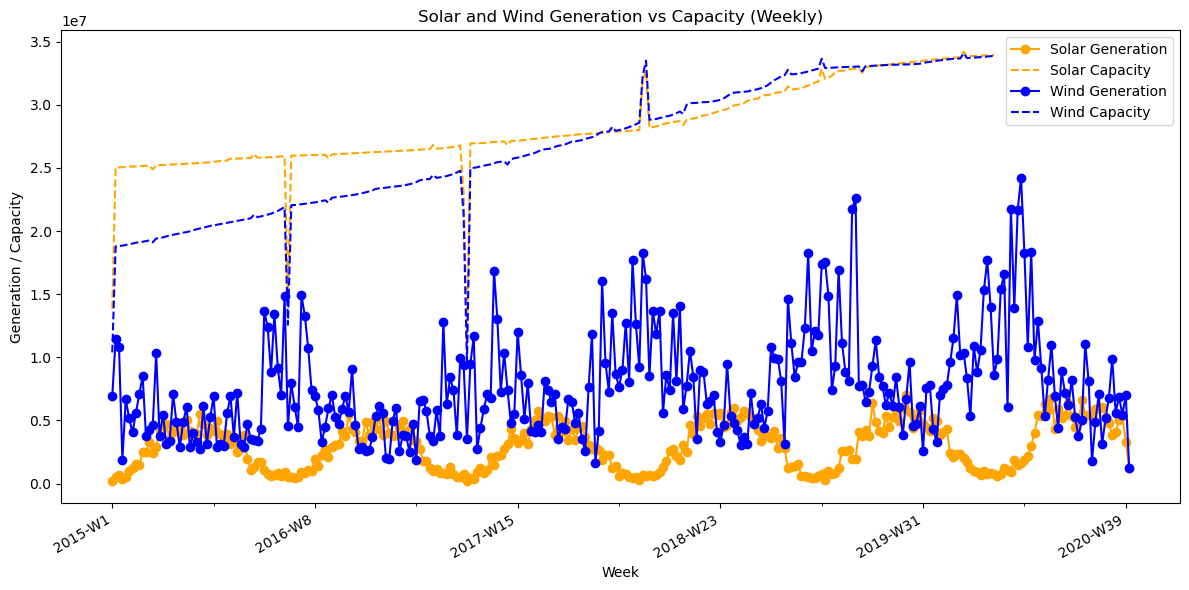

In [27]:

# Convert the Spark DataFrame to Pandas for easier plotting
result_pd = weekly_gen_df_sql.toPandas()

# Create a new column for the week (combining year and week number)
result_pd['week_label'] = result_pd['year'].astype(str) + '-W' + result_pd['week'].astype(str)

# Plotting the data
plt.figure(figsize=(12, 6))

# Plot solar generation vs capacity
plt.plot(result_pd['week_label'], result_pd['total_solar_generation'], label='Solar Generation', color='orange', marker='o')
plt.plot(result_pd['week_label'], result_pd['total_solar_capacity'], label='Solar Capacity', color='orange', linestyle='--')

# Plot wind generation vs capacity
plt.plot(result_pd['week_label'], result_pd['total_wind_generation'], label='Wind Generation', color='blue', marker='o')
plt.plot(result_pd['week_label'], result_pd['total_wind_capacity'], label='Wind Capacity', color='blue', linestyle='--')

# Adding labels and title
plt.xlabel('Week')
plt.ylabel('Generation / Capacity')
plt.title('Solar and Wind Generation vs Capacity (Weekly)')
plt.legend()

# Rotate x-axis labels for better readability
#add years to x-axis labels
plt.xticks(rotation=45)
# Set x-axis major locator to show every 4 weeks
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(4))

plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6, prune='both'))
plt.gca().xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12, prune='both'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()
